# Speed it up: Just-In-Time Compiler

In [1]:
import math
import random
import numpy as np
import numba
from matplotlib import pyplot as plt

---
# Compile it with Numba!
One of my favorite Python libraries is `Numba`. If `Numpy` or other greate libraries still don't offer the right functions for your problem, than this is the perfect way to build very performant functions yourself (without any need to switch to C/C++ or other languages).

### Compiling modes
Numba offers several compilation modes. Typically we will work with
- `nopython = True` which will raise an error if compilation in the fast "nopython mode" won't work
- `nogil = True` which can be used to avoid the restrictions of the GIL (global interpreter lock), but also requires a better understanding of what this means...
- `parallel = True` which enabels automatic parallelization (we will see more on this in a bit).

See also [Numba documentation on compiling options](https://numba.readthedocs.io/en/stable/user/jit.html).

Or the [Numba 5 minutes guide](https://numba.pydata.org/numba-doc/latest/user/5minguide.html).

### Reminder: last weeks options were Python vs. Numpy

In [2]:
%timeit sum(range(10**7))

203 ms ± 37.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
def sum_range(N):
    """Compute the sum of the numbers in the range [0, N)."""
    total = 0
    for i in range(N):
        total += i
    return total

In [4]:
%timeit sum_range(10**7)

681 ms ± 91.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numpy version:

In [5]:
import numpy as np

%timeit np.arange(10**7).sum()

26.3 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Numba version:
In this example, numba has a couple of advantages.
First, it does not require to rethink the problem to convert it into a vectorized (*or numpy-fied*) version. This does not always work, but here it will.

Second, the numpy solution is not very elegant here and has a huge downside: it requires writing a full array of all numbers from $0$ to $10^7$ to memory, while the Python (and the numba) version only keep track of the one value stored in `total`.

In [6]:
import numba

@numba.jit(nopython=True)
def sum_range_numba(N):
    """Compute the sum of the numbers in the range [0, N)."""
    total = 0
    for i in range(N):
        total += i
    return total

In [7]:
%time sum_range_numba(10**7)

CPU times: total: 453 ms
Wall time: 480 ms


49999995000000

In [8]:
%timeit sum_range_numba(10**7)

The slowest run took 48.50 times longer than the fastest. This could mean that an intermediate result is being cached.
1.67 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
# second run:
%timeit sum_range_numba(10**7)

116 ns ± 4.57 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [15]:
%%time
sum_range_numba(1e9)

CPU times: total: 0 ns
Wall time: 0 ns


499999999500000000

## Wow! Does this always do the trick?
Sadly: no.

Numba compiles the code and this means we loose some aspects of what Python code can do.
With compiling, something that is not really important in Python suddently becomes very important: **the data type**.

Numba works best with Numpy data types and functions as well as basic Python data types and code.
In general Numba supports the following:
- Windows (32 and 64 bit), OSX and Linux (32 and 64 bit)
- Architectures: x86, x86_64, ppc64le. Experimental on armv7l, armv8l (aarch64).
- GPUs: Nvidia CUDA. Experimental on AMD ROC.
- CPython (hence no Jython or others)
- NumPy >= 1.15


In [9]:
import pandas as pd

df = pd.DataFrame({"A": [2, 3, 4, 5],
                   "B": [0, -1, 0, -5],
                  })

@numba.jit(nopython=True)
def get_max(df):
    return df.max()

get_max(df)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at C:\Users\flori\AppData\Local\Temp\ipykernel_16324\1526091316.py (7)[0m
[1m
File "..\..\..\..\..\Users\flori\AppData\Local\Temp\ipykernel_16324\1526091316.py", line 7:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'pandas.core.frame.DataFrame'>[0m


In [10]:
@numba.jit(nopython=True)
def do_python_stuff():
    x = [5, 6]
    x.append(2)
    return x

do_python_stuff()

[5, 6, 2]

In [11]:
@numba.jit(nopython=True)
def do_python_stuff():
    x = [5, 6]
    x.append("seven")
    return x

do_python_stuff()

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mInvalid use of BoundFunction(list.append for list(int64)<iv=[5, 6]>) with parameters (Literal[str](seven))
[0m
[0m[1mDuring: resolving callee type: BoundFunction(list.append for list(int64)<iv=[5, 6]>)[0m
[0m[1mDuring: typing of call at C:\Users\flori\AppData\Local\Temp\ipykernel_16324\1133039490.py (4)[0m
[1m
File "..\..\..\..\..\Users\flori\AppData\Local\Temp\ipykernel_16324\1133039490.py", line 4:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m

## Use case: simulation (diffusion process)
A diffusion process in form of Brownian motion can be simulated by small random changes to the position of all particles.
This requires updating the position of *every particle* a tiny bit for *many time steps* in a row. This makes it compute-intensive.

In [2]:
import random

# Initialize particles
n_particles = 1000
particles_x = [random.uniform(-1, 1) for _ in range(n_particles)]
particles_y = [random.uniform(-1, 1) for _ in range(n_particles)]

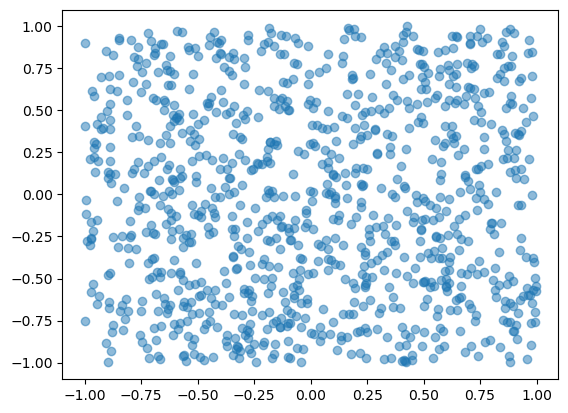

In [3]:
plt.scatter(particles_x, particles_y, alpha=0.5)

In [14]:
[random.gauss(0, 0.1) for _ in range(10)]

[0.14898792559277851,
 0.041063581281179644,
 0.005552700055338093,
 0.01954128999427389,
 -0.06442298307782034,
 0.10032716068812333,
 0.060117481677225575,
 -0.025782600184434037,
 -0.18742627501951836,
 0.015347925697062687]

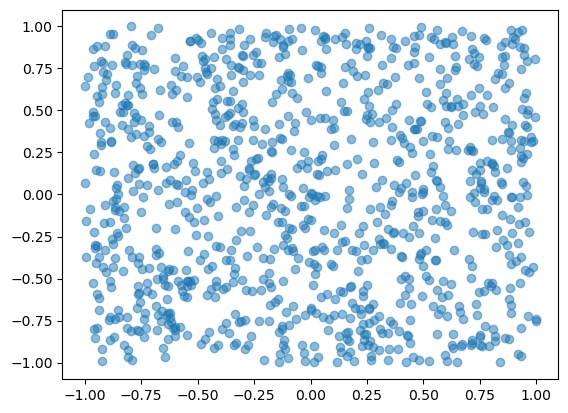

In [20]:
plt.scatter(particles_x, particles_y, alpha=0.5)

In [21]:
def diffusion_python(particles_x, particles_y, n_timesteps):
    for _ in range(n_timesteps):
        particles_x = [x + random.gauss(0, 0.1) for x in particles_x]
        particles_y = [y + random.gauss(0, 0.1) for y in particles_y]

    return particles_x, particles_y

x, y = diffusion_python(particles_x, particles_y, 10)

## Check runtime:

In [22]:
%%time
# Initialize particles
n_particles = 10000
particles_x = [random.uniform(-1, 1) for _ in range(n_particles)]
particles_y = [random.uniform(-1, 1) for _ in range(n_particles)]

x, y = diffusion_python(particles_x, particles_y, 200)

CPU times: total: 2.36 s
Wall time: 2.39 s


## Numba-fy your code!
Now, please try to convert the `diffusion_python` function to a just-in-time compiled `diffusion_numba` function.

Try by simply using the `@numba.jit(nopython=True)` decorator.

In [4]:
@numba.jit(nopython=True)
def diffusion_numba(particles_x, particles_y, n_timesteps):
    for _ in range(n_timesteps):
        particles_x = [x + random.gauss(0, 0.1) for x in particles_x]
        particles_y = [y + random.gauss(0, 0.1) for y in particles_y]

    return particles_x, particles_y

In [24]:
%%time

# Initialize particles
particles_x = [random.uniform(-1, 1) for _ in range(n_particles)]
particles_y = [random.uniform(-1, 1) for _ in range(n_particles)]

x, y = diffusion_numba(particles_x, particles_y, 200)

CPU times: total: 766 ms
Wall time: 851 ms


## What happend during our diffusion simulation?

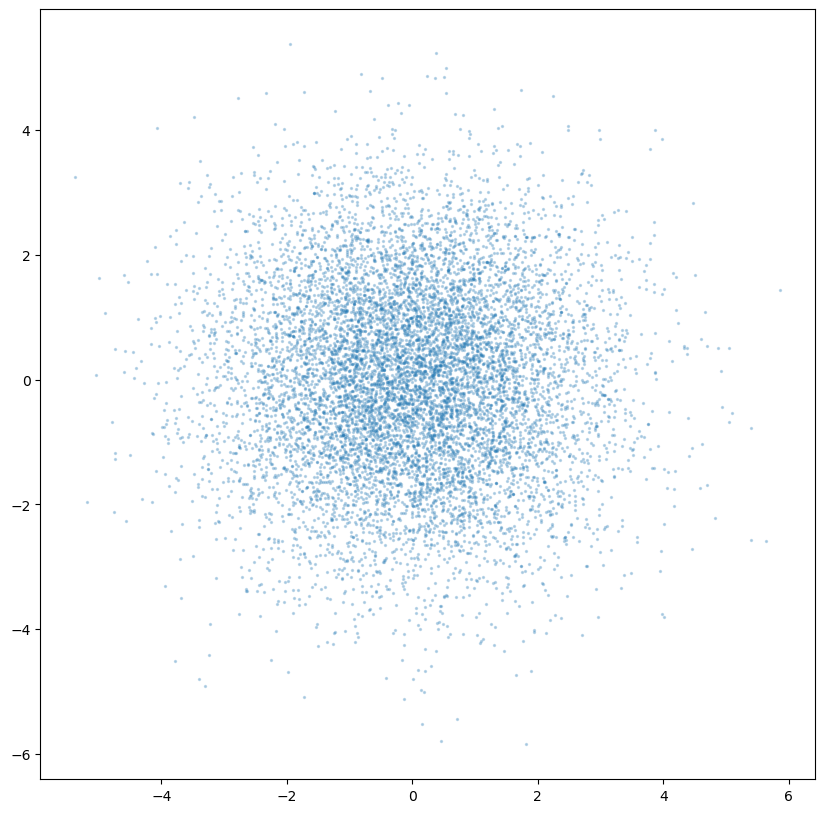

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(x, y, alpha=0.25, s=2)

## Numpy-fy your code!

In [5]:
import numpy as np

def diffusion_numpy(particles, n_timesteps):
    for _ in range(n_timesteps):
        particles += np.random.randn(particles.shape[0], particles.shape[1])

    return particles

In [6]:
%%time
# Initialize particles
n_particles = 10000
particles = np.random.uniform(-1, 1, size=(n_particles, 2))

particles = diffusion_numpy(particles, 200)

CPU times: total: 172 ms
Wall time: 166 ms


In [44]:
particles.shape

(10000, 2)

## Still rather new: classes with numba

In [20]:
import numpy as np
from numba import int32, float32    # import the types
from numba.experimental import jitclass

spec = [
    ('n_particles', int32),   # scalar field must be declared
    ('_x', float32[:]),       # an array field
    ('_y', float32[:]),       # an array field
]

@jitclass(spec)
class Particles(object):
    def __init__(self, n_particles):
        self.n_particles = n_particles
        self._x = np.zeros(self.n_particles, dtype=np.float32)
        self._y = np.zeros(self.n_particles, dtype=np.float32)

    @property
    def x(self):
        return self._x

    @property
    def y(self):
        return self._y

    def diffuse(self, step_size):
        # 1D noise matching the shape of _x and _y
        # cast to float32 to match the array dtype
        self._x += step_size * np.random.randn(self.n_particles).astype(np.float32)
        self._y += step_size * np.random.randn(self.n_particles).astype(np.float32)


ps = Particles(100)
ps.diffuse(1.0)
print(ps.x[:5], ps.y[:5])


[ 0.62265784  2.4162076  -0.3293103   1.6548007  -0.04408215] [ 0.3667833  -0.37607998  0.12692903 -1.0218116  -1.8503004 ]


In [25]:
ps = Particles(100000)

In [26]:
%time ps.diffuse(1.0)

CPU times: total: 15.6 ms
Wall time: 11 ms


## Try to parallelize --> probably better within 2nd parallelization session

"Embarassingly parallel" --> `range` --> `prange`

In [7]:
@numba.jit(nopython=True, parallel=True)
def diffusion_numba_parallel(n_particles, n_timesteps):
    # Initialize particles
    particles = [[random.uniform(-1, 1), random.uniform(-1, 1)] for _ in range(n_particles)]

    for i, particle in enumerate(particles):
        for _ in numba.prange(n_timesteps):
            particles[i] = [particle[0] + random.gauss(0, 0.1), particle[1] + random.gauss(0, 0.1)]

    return particles

In [ ]:
# Will kill kernel!
%%time
particles = diffusion_numba_parallel(10000, 200)

In [45]:
import numba
import numpy as np
from numba import prange

@numba.jit(nopython=True, parallel=True)
def diffusion_numba_parallel(n_particles, n_timesteps):
    # Initialize particles using a NumPy array
    particles = np.random.uniform(-1, 1, (n_particles, 2))

    for i in prange(n_particles):
        for t in range(n_timesteps):
            dx = np.random.normal(0, 0.1)
            dy = np.random.normal(0, 0.1)
            particles[i, 0] += dx
            particles[i, 1] += dy

    return particles

In [51]:
%%time
particles = diffusion_numba_parallel(10000, 200)

CPU times: total: 15.6 ms
Wall time: 12.1 ms
